In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from glob import glob
import matplotlib.pyplot as plt

In [2]:
train_dir = r'chest_xray\train'
test_dir = r'chest_xray\test'
val_dir = r'chest_xray\val'

In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

val_set = test_datagen.flow_from_directory('chest_xray/val',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 8s 0us/step


In [7]:
for layer in inception.layers:
    layer.trainable = False

In [8]:
x = Flatten()(inception.output)

In [9]:
folders = glob('chest_xray/train/*')
print(folders)

['chest_xray/train\\NORMAL', 'chest_xray/train\\PNEUMONIA']


In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
model = Model(inputs=inception.input, outputs=prediction)

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,      # how many epochs to wait before stopping
    restore_best_weights=True
)

In [14]:
r = model.fit(
    training_set,
    validation_data=val_set,
    epochs=500,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set),
    callbacks=[early_stopping]
)

Epoch 1/500
163/163 [==============================] - 199s 1s/step - loss: 0.7695 - accuracy: 0.9105 - val_loss: 0.6091 - val_accuracy: 0.8125
Epoch 2/500
163/163 [==============================] - 204s 1s/step - loss: 0.8435 - accuracy: 0.9204 - val_loss: 3.2725 - val_accuracy: 0.6875
Epoch 3/500
163/163 [==============================] - 172s 1s/step - loss: 0.8015 - accuracy: 0.9354 - val_loss: 6.9303 - val_accuracy: 0.6875
Epoch 4/500
163/163 [==============================] - 285s 2s/step - loss: 0.6561 - accuracy: 0.9410 - val_loss: 3.5853 - val_accuracy: 0.7500
Epoch 5/500
163/163 [==============================] - 230s 1s/step - loss: 0.4941 - accuracy: 0.9544 - val_loss: 2.6357 - val_accuracy: 0.8125
Epoch 6/500
163/163 [==============================] - 163s 1s/step - loss: 0.6044 - accuracy: 0.9471 - val_loss: 3.0022 - val_accuracy: 0.8125
Epoch 7/500
163/163 [==============================] - 168s 1s/step - loss: 0.5365 - accuracy: 0.9549 - val_loss: 5.0086 - val_accuracy:

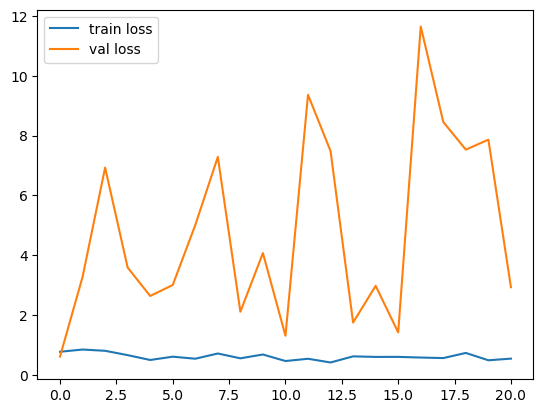

In [15]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

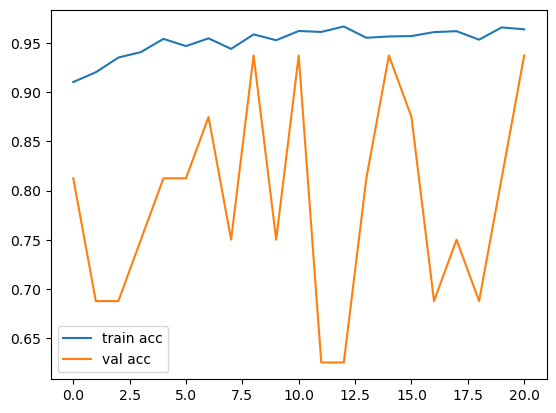

In [16]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
model.save_weights('inception_pneumonia_weights.h5')
model.save('inception_pneumonia_model.h5')